# Raleigh Traffic Stops

Date: February 7, 2023

Recreate analysis from Frank R. Baumgartner's [Benchmarking Traffic Stop Data: Examining Patterns in North Carolina and the City of Raleigh](https://fbaum.unc.edu/TrafficStops/Baumgartner-benchmarking.pdf).

In [1]:
import logging


def configure_root_logger():
    console_logger = logging.StreamHandler()
    console_logger.setLevel(logging.DEBUG)
    console_logger.setFormatter(
        logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")
    )

    logger = logging.getLogger()
    logger.handlers = []  # reset handlers in case this cell is re-run
    logger.setLevel(logging.DEBUG)
    logger.addHandler(console_logger)
    return logger

In [2]:
import os

from sqlalchemy import create_engine

from dash import Dash, html, dcc
import plotly.express as px
import pandas as pd

In [3]:
import plotly
plotly.offline.init_notebook_mode()

In [4]:
logger = configure_root_logger()
pg_engine = create_engine("postgresql://postgres@db:5432/traffic_stops_nc")
pg_conn = pg_engine.connect()

# Data prep

In [5]:
def lookup_agencies(agency_names):
    return pd.read_sql(
        f"""
        SELECT
            id
            , name
        FROM nc_agency
        WHERE name ~ '{"|".join(agency_names)}'
        ORDER BY 2
        """,
        pg_conn,
    )
df = lookup_agencies({
    "Raleigh",
})
agency_ids = df['id'].tolist()
df

id                       name
0  225  Raleigh Police Department

In [6]:
from enum import Enum

class StopPurpose(Enum):
    SPEED_LIMIT_VIOLATION         = 1   # Safety Violation
    STOP_LIGHT_SIGN_VIOLATION     = 2   # Safety Violation
    DRIVING_WHILE_IMPAIRED        = 3   # Safety Violation
    SAFE_MOVEMENT_VIOLATION       = 4   # Safety Violation
    VEHICLE_EQUIPMENT_VIOLATION   = 5   # Regulatory and Equipment
    VEHICLE_REGULATORY_VIOLATION  = 6   # Regulatory and Equipment
    OTHER_MOTOR_VEHICLE_VIOLATION = 9   # Regulatory and Equipment
    SEAT_BELT_VIOLATION           = 7   # Investigatory
    INVESTIGATION                 = 8   # Investigatory
    CHECKPOINT                    = 10  # Investigatory
    
    @classmethod
    def safety_violation(cls):
        return [cls.SPEED_LIMIT_VIOLATION.value, cls.STOP_LIGHT_SIGN_VIOLATION.value, cls.DRIVING_WHILE_IMPAIRED.value, cls.SAFE_MOVEMENT_VIOLATION.value]
    
    @classmethod
    def regulatory_equipment(cls):
        return [cls.VEHICLE_EQUIPMENT_VIOLATION.value, cls.VEHICLE_REGULATORY_VIOLATION.value, cls.OTHER_MOTOR_VEHICLE_VIOLATION.value]
    
    @classmethod
    def investigatory(cls):
        return [cls.SEAT_BELT_VIOLATION.value, cls.INVESTIGATION.value, cls.CHECKPOINT.value]

In [7]:
stops_summary_sql = f"""
SELECT
    nc_stop.stop_id
    , date AT TIME ZONE 'America/New_York' AS stop_date
    , EXTRACT(hour FROM date AT TIME ZONE 'America/New_York') AS "hour_of_day"
    , nc_stop.agency_id
    , nc_stop.agency_description AS agency
    , nc_stop.officer_id
    , (CASE WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.safety_violation()))}) THEN 'Safety Violation'
            WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.investigatory()))}) THEN 'Investigatory'
            WHEN nc_stop.purpose IN ({",".join(map(str, StopPurpose.regulatory_equipment()))}) THEN 'Regulatory and Equipment'
            ELSE 'Other'
       END) as stop_purpose_group
    , (CASE WHEN nc_person.ethnicity = 'H' THEN 'Hispanic'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'A' THEN 'Asian'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'B' THEN 'Black'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'I' THEN 'Native American'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'U' THEN 'Other'
            WHEN nc_person.ethnicity = 'N' AND nc_person.race = 'W' THEN 'White'
       END) as driver_race
    , (CASE WHEN nc_person.gender = 'M' THEN 'male'
            WHEN nc_person.gender = 'F' THEN 'female'
       END) as driver_gender
    , (nc_search.search_id IS NOT NULL) AS driver_searched
    , (CASE
        WHEN nc_contraband.contraband_id IS NULL THEN false
        ELSE true
        END) AS contraband_found
    , driver_arrest
FROM "nc_stop"
INNER JOIN "nc_person"
    ON ("nc_stop"."stop_id" = "nc_person"."stop_id" AND "nc_person"."type" = 'D')
LEFT OUTER JOIN "nc_search"
    ON ("nc_stop"."stop_id" = "nc_search"."stop_id")
LEFT OUTER JOIN "nc_contraband"
    ON ("nc_stop"."stop_id" = "nc_contraband"."stop_id")
WHERE nc_stop.agency_id IN ({",".join(map(str, agency_ids))})
"""

# Figures

## Figure 1: Percent of stops for safety-related purposes, by race, gender, and hour of day

In [8]:
df = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        hour_of_day
        , stop_purpose_group
        , driver_race
        , driver_gender
        , count(*) AS stop_count
        , sum(count(*)) OVER (PARTITION BY hour_of_day, driver_race, driver_gender)::integer AS total_hour_stops_by_race
    FROM stops
    GROUP BY 1, 2, 3, 4
    """,
    pg_engine,
)
df["percent_stops_for_race_gender"] = df.stop_count / df.total_hour_stops_by_race

In [9]:
black_drivers = df["driver_race"] == "Black"
male_drivers = df["driver_gender"] == "male"
midnight = df["hour_of_day"] == 0
df[black_drivers & male_drivers & midnight]

hour_of_day        stop_purpose_group driver_race driver_gender  \
9           0.0          Safety Violation       Black          male   
10          0.0  Regulatory and Equipment       Black          male   
11          0.0             Investigatory       Black          male   

    stop_count  total_hour_stops_by_race  percent_stops_for_race_gender  
9         7442                     21350                       0.348571  
10       12714                     21350                       0.595504  
11        1194                     21350                       0.055925

In [10]:
df[black_drivers & male_drivers & midnight].stop_count.sum()

21350

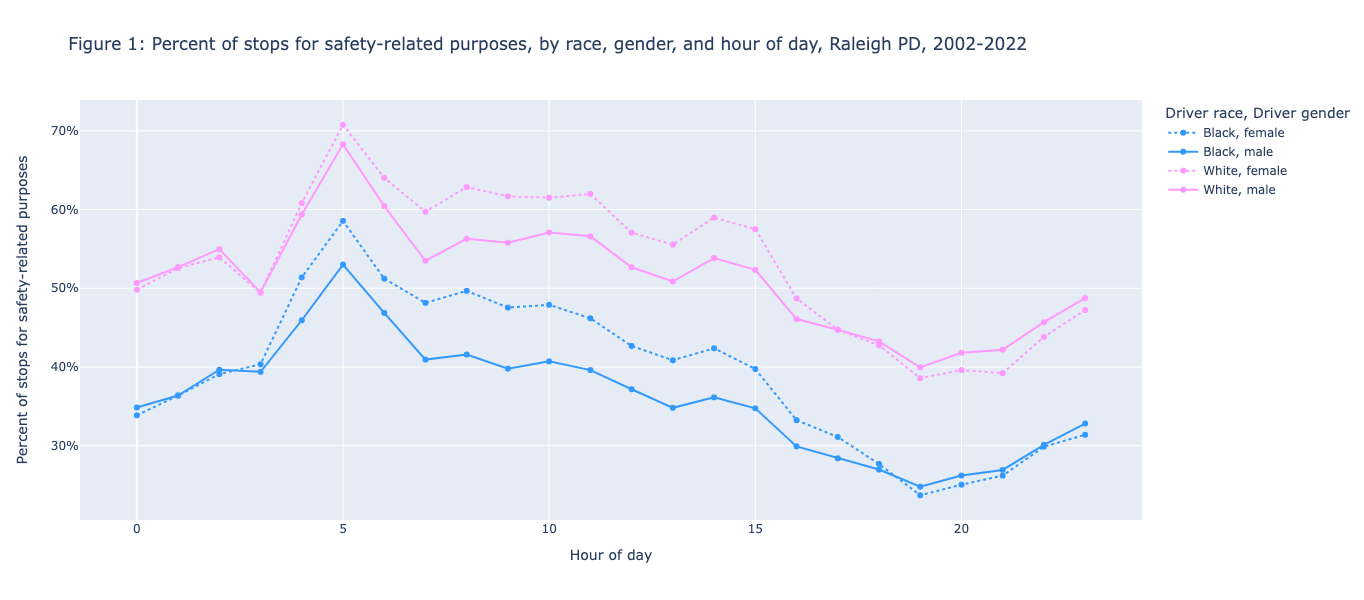

In [11]:
mask = (df["stop_purpose_group"] == "Safety Violation") & (df["driver_race"].isin(["Black", "White"]))
fig = px.line(
    df[mask],
    x="hour_of_day",
    y='percent_stops_for_race_gender',
    color="driver_race",
    title="Figure 1: Percent of stops for safety-related purposes, by race, gender, and hour of day, Raleigh PD, 2002-2022",
    labels={
        'percent_stops_for_race_gender': 'Percent of stops for safety-related purposes',
        'hour_of_day': 'Hour of day',
        "driver_race": "Driver race",
        "driver_gender": "Driver gender"
    },
    color_discrete_sequence=(px.colors.diverging.Picnic[1], px.colors.diverging.Picnic[7]),
    height=600,
    markers=True,
    line_dash="driver_gender",
    line_dash_map={"male": "solid", "female": "dot"},
    line_group="driver_gender",
)
fig.layout.yaxis.tickformat = ',.0%'
fig.update_traces(textposition="bottom right")

> Safety-related stops are moving violations and may be more likely to be related to keeping the roads safe. Other traffic stops may be more related to the desire to conduct an informal criminal investigation. (Baumgartner, p8)

> Black drivers, whether male or female, are much more likely to be stopped for reasons other than moving violations, particularly in the evening and at night. White drivers, particularly white women, are much more likely to be stopped for moving violations. **The numbers are stark: at any given time of the day..., white drivers may be 20 percent higher in their share of safety-related stops than black drivers**. At noon, for example, black male drivers show a value of 40 percent safety-related stops but white female drivers show a value around 60 percent. (Baumgartner, p9)

In [12]:
# fig = px.colors.diverging.swatches()
# fig.show()

## Figure 2. Percent of traffic stops by race, gender, and hour of day

In [13]:
df2 = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        hour_of_day
        , driver_race
        , driver_gender
        , count(*) AS stop_count
        , sum(count(*)) OVER (PARTITION BY hour_of_day)::integer AS total_hour_stops
    FROM stops
    GROUP BY 1, 2, 3
    """,
    pg_engine,
)
df2["percent_stops_for_race_gender"] = df2.stop_count / df2.total_hour_stops

In [14]:
midnight = df2["hour_of_day"] == 0
df2[midnight]

hour_of_day      driver_race driver_gender  stop_count  total_hour_stops  \
0           0.0            Asian        female         289             59090   
1           0.0            Asian          male         842             59090   
2           0.0            Black        female        9757             59090   
3           0.0            Black          male       21350             59090   
4           0.0         Hispanic        female        1176             59090   
5           0.0         Hispanic          male        4401             59090   
6           0.0  Native American        female          10             59090   
7           0.0  Native American          male          25             59090   
8           0.0            Other        female          97             59090   
9           0.0            Other          male         645             59090   
10          0.0            White        female        6577             59090   
11          0.0            White          male       13921             59090   

    percent_stops_for_race_gender  
0                        0.004891  
1                        0.014249  
2                        0.165121  
3                        0.361313  
4                        0.019902  
5                        0.074480  
6                        0.000169  
7                        0.000423  
8                        0.001642  
9                        0.010916  
10                       0.111305  
11                       0.235590

In [15]:
df2[midnight].stop_count.sum()

59090

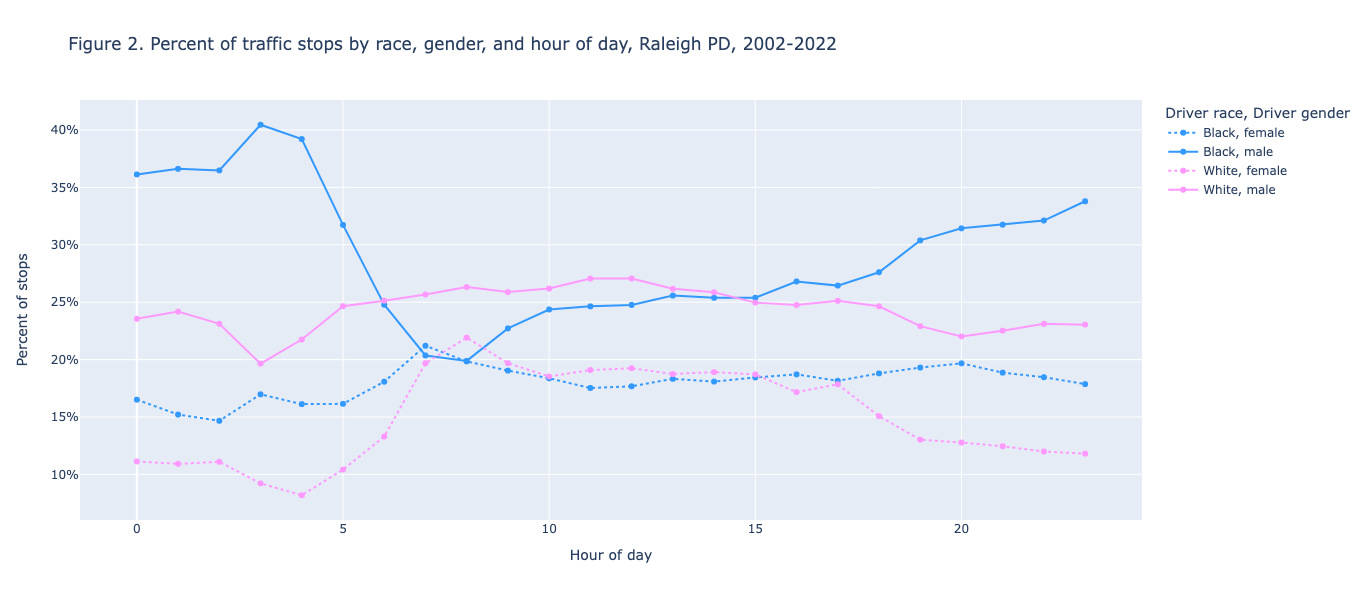

In [16]:
mask = df2["driver_race"].isin(["Black", "White"])
fig = px.line(
    df2[mask],
    x="hour_of_day",
    y='percent_stops_for_race_gender',
    color="driver_race",
    title="Figure 2. Percent of traffic stops by race, gender, and hour of day, Raleigh PD, 2002-2022",
    labels={
        'percent_stops_for_race_gender': 'Percent of stops',
        'hour_of_day': 'Hour of day',
        "driver_race": "Driver race",
        "driver_gender": "Driver gender"
    },
    color_discrete_sequence=(px.colors.diverging.Picnic[1], px.colors.diverging.Picnic[7]),
    height=600,
    markers=True,
    line_dash="driver_gender",
    line_dash_map={"male": "solid", "female": "dot"},
    line_group="driver_gender",
)
fig.layout.yaxis.tickformat = ',.0%'
fig.update_traces(textposition="bottom right")

> Figure 2 shows how drivers of different race and gender characteristics represent a different share of overall traffic stops by time of the day. (Baumgartner, p9)

> **Black males are more than 35 percent of those pulled over during the period following midnight, but only 20 percent of drivers stopped during the morning daylight hours. White men, by contrast, show a relatively consistent pattern throughout the day. Why would this be? It may be because the traffic stop is a convenient tool for a police officer to conduct an informal criminal investigation.** Officers can find a reason to pull over virtually any car, and without unduly prolonging the traffic stop, they may ask questions about the driver’s identity and plans. This may involve a request to search the car, or a decision that probable cause of some kind of contraband or criminal activity is apparent. (Baumgartner, p10)

## Figure 3. Percent of drivers searched by race, gender, and hour of day

In [17]:
df3 = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        hour_of_day
        , driver_race
        , driver_gender
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
    FROM stops
    GROUP BY 1, 2, 3
    """,
    pg_engine,
)
df3["percent_stops_searched"] = df3.search_count / df3.stop_count

In [18]:
black_white_drivers = df3["driver_race"].isin(["Black", "White"])
midnight = df3["hour_of_day"] == 0
df3[black_white_drivers & midnight]

hour_of_day driver_race driver_gender  stop_count  search_count  \
2           0.0       Black        female        9757           402   
3           0.0       Black          male       21350          1995   
10          0.0       White        female        6577           315   
11          0.0       White          male       13921           949   

    percent_stops_searched  
2                 0.041201  
3                 0.093443  
10                0.047894  
11                0.068170

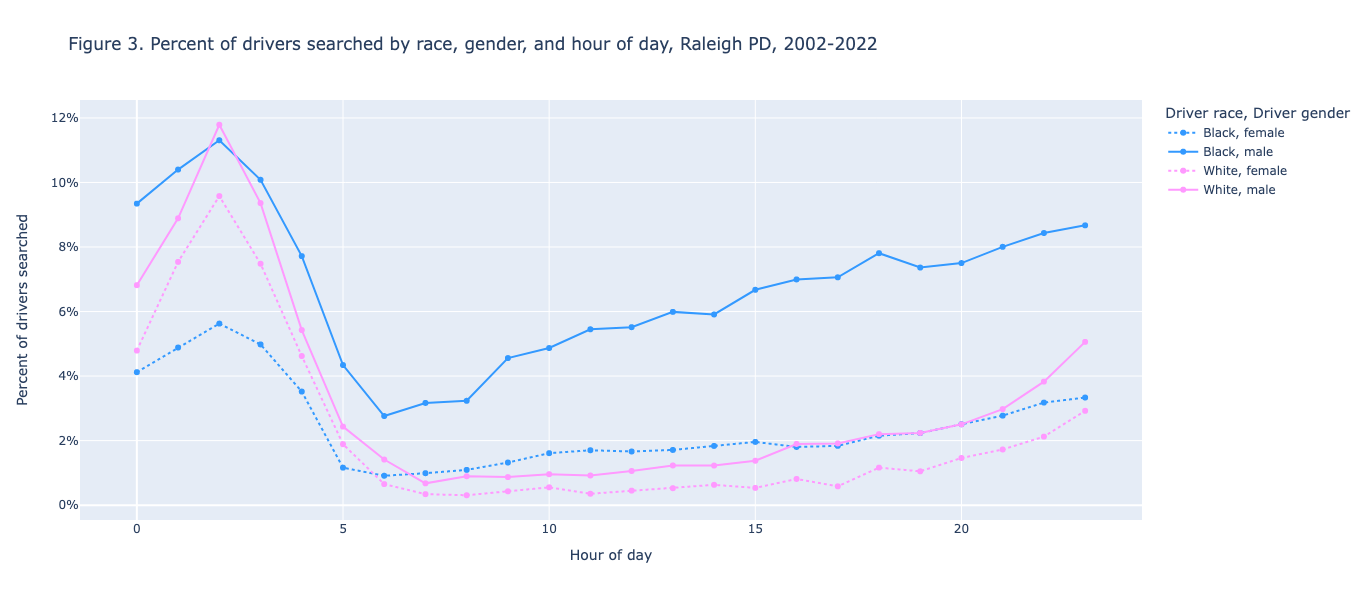

In [19]:
mask = df3["driver_race"].isin(["Black", "White"])
fig = px.line(
    df3[mask],
    x="hour_of_day",
    y='percent_stops_searched',
    color="driver_race",
    title="Figure 3. Percent of drivers searched by race, gender, and hour of day, Raleigh PD, 2002-2022",
    labels={
        'percent_stops_searched': 'Percent of drivers searched',
        'hour_of_day': 'Hour of day',
        "driver_race": "Driver race",
        "driver_gender": "Driver gender"
    },
    color_discrete_sequence=(px.colors.diverging.Picnic[1], px.colors.diverging.Picnic[7]),
    height=600,
    markers=True,
    line_dash="driver_gender",
    line_dash_map={"male": "solid", "female": "dot"},
    line_group="driver_gender",
)
fig.layout.yaxis.tickformat = ',.0%'
fig.update_traces(textposition="bottom right")

> Figure 3 shows the percent of drivers subjected to a search. With the exception of driving while impaired, most traffic or vehicle infractions do not involve an arrest... Rather, arrests come from criminal investigations relating to the presence of contraband. **When traffic stops divert from the purpose of keeping the roads safe from poor driving behaviors and into informal criminal investigations, as they often do, then black drivers, particularly males, are subjected to significantly more scrutiny.** (Baumgartner, p10-11)

> Several things are noteworthy with regards to Figures 3 and 4. **First, rates are very low; the vast majority of traffic stops involve neither a search nor an arrest, including for black drivers. Second, they vary dramatically by time of day. It appears that the very purpose and function of a traffic stop differs between daylight, evening, and the after-midnight period. And finally, there are strong differences in odds of search and arrest by driver race, with black male drivers being much more likely to see these outcomes.** (Baumgartner, p12)

## Figure 4. Percent of drivers arrested by race, gender, and hour of day

In [20]:
df4 = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        hour_of_day
        , driver_race
        , driver_gender
        , count(*) AS stop_count
        , count(*) FILTER (WHERE driver_searched = true) AS search_count
        , count(*) FILTER (WHERE driver_arrest = true) AS driver_arrest_count
    FROM stops
    GROUP BY 1, 2, 3
    """,
    pg_engine,
)
df4["percent_drivers_arrested"] = df4.driver_arrest_count / df4.stop_count

In [21]:
black_white_drivers = df4["driver_race"].isin(["Black", "White"])
midnight = df4["hour_of_day"] == 0
df4[black_white_drivers & midnight]

hour_of_day driver_race driver_gender  stop_count  search_count  \
2           0.0       Black        female        9757           402   
3           0.0       Black          male       21350          1995   
10          0.0       White        female        6577           315   
11          0.0       White          male       13921           949   

    driver_arrest_count  percent_drivers_arrested  
2                   171                  0.017526  
3                   596                  0.027916  
10                  173                  0.026304  
11                  437                  0.031391

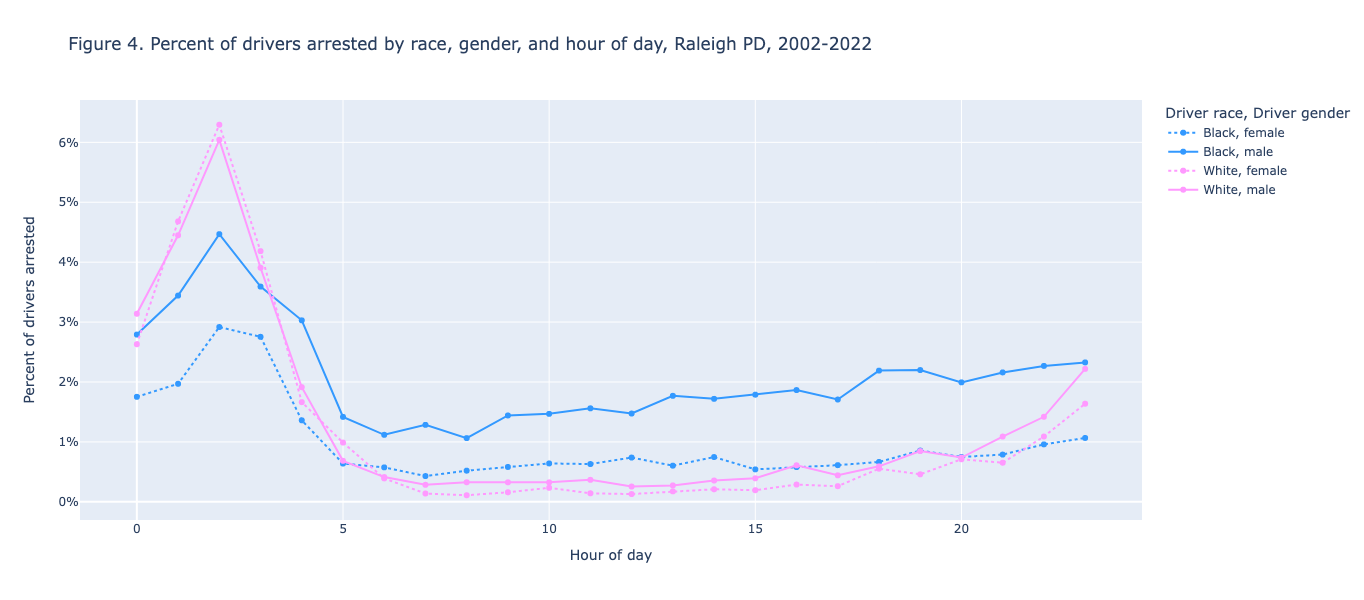

In [22]:
mask = df4["driver_race"].isin(["Black", "White"])
fig = px.line(
    df4[mask],
    x="hour_of_day",
    y='percent_drivers_arrested',
    color="driver_race",
    title="Figure 4. Percent of drivers arrested by race, gender, and hour of day, Raleigh PD, 2002-2022",
    labels={
        'percent_drivers_arrested': 'Percent of drivers arrested',
        'hour_of_day': 'Hour of day',
        "driver_race": "Driver race",
        "driver_gender": "Driver gender"
    },
    color_discrete_sequence=(px.colors.diverging.Picnic[1], px.colors.diverging.Picnic[7]),
    height=600,
    markers=True,
    line_dash="driver_gender",
    line_dash_map={"male": "solid", "female": "dot"},
    line_group="driver_gender",
)
fig.layout.yaxis.tickformat = ',.0%'
fig.update_traces(textposition="bottom right")

## Figure 5. Percent of black of drivers pulled over

In [23]:
df5 = pd.read_sql(
    f"""
    WITH stops AS ({stops_summary_sql})
    SELECT
        officer_id
        , driver_race
        , count(*) AS stop_count
        , sum(count(*)) OVER (PARTITION BY officer_id)::integer AS total_by_officer

    FROM stops
    GROUP BY 1, 2
    """,
    pg_engine,
)
df5["percent_drivers_stopped"] = df5.stop_count / df5.total_by_officer

In [24]:
minimum_100_stops = df5["total_by_officer"] >= 100
black_drivers = df5["driver_race"] == "Black"
black_and_white_drivers = df5["driver_race"].isin(["Black", "White"])

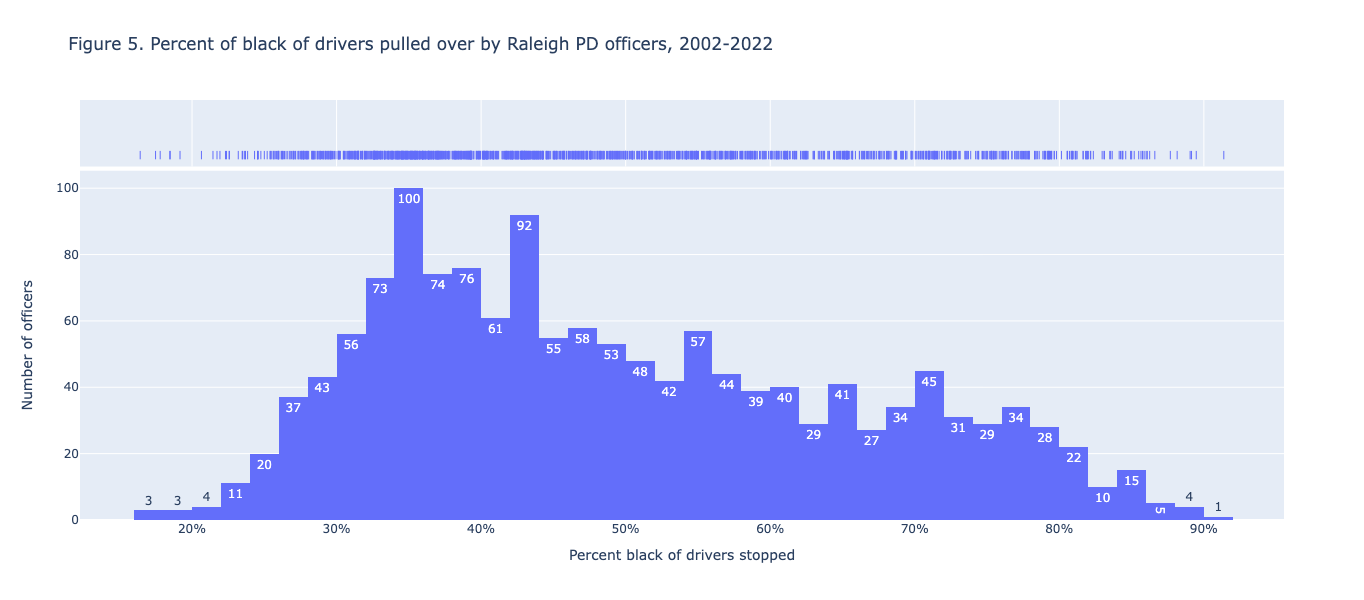

In [25]:
mask = black_drivers & minimum_100_stops
fig = px.histogram(
    df5[mask],
    title="Figure 5. Percent of black of drivers pulled over by Raleigh PD officers, 2002-2022",
    x="percent_drivers_stopped",
    labels={
        'percent_drivers_stopped': 'Percent black of drivers stopped',
    },
    height=600,
    marginal="rug",
    text_auto=True,
)
fig.layout.xaxis.tickformat = ',.0%'
fig.update_layout(yaxis_title="Number of officers")
fig.show()

> Figure 5 shows such results for over \[1,400\] officers in the Raleigh Police Department, all those who reported at least 100 traffic stops during the period of 2002 to \[2022\]. For each officer it reports the percentage of drivers pulled over who were black. (Baumgartner, p12)

> ...**the population of Raleigh is approximately 26 percent black. However, just 41 officers, or less than 3 percent of those shown, have a lower share of black drivers. If traffic stops were racially neutral with regards to the local population, half of the officers would be below the population average and half would be above it. Instead, we see that the average officer pulls over 46 black drivers out of 100 traffic stops, nearly twice the population average...** A significant share of officers pull over 75 or more black drivers for every 100 traffic stops they make. For any given officer, the further to the right on this graph, the greater the disparity of their stops compared to the population average. (Baumgartner, p13)

## Figure 5a. Percent of drivers pulled over

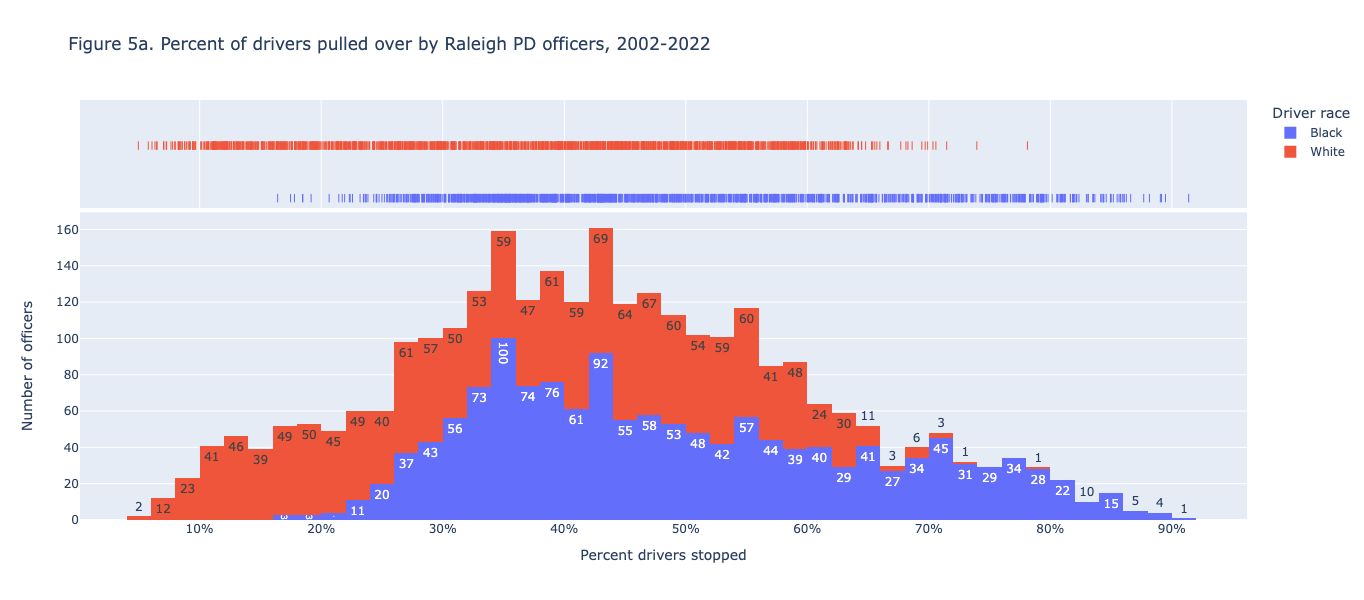

In [26]:
mask = black_and_white_drivers & minimum_100_stops
fig = px.histogram(
    df5[mask],
    title="Figure 5a. Percent of drivers pulled over by Raleigh PD officers, 2002-2022",
    color="driver_race",
    x="percent_drivers_stopped",
    labels={
        'percent_drivers_stopped': 'Percent drivers stopped',
        'driver_race': 'Driver race',
    },
    height=600,
    marginal="rug",
    text_auto=True,
)
fig.layout.xaxis.tickformat = ',.0%'
fig.update_layout(yaxis_title="Number of officers")
fig.show()